In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder

import os

import optuna
from optuna.trial import TrialState

/home/cscadmin/miniconda3/envs/torch-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on

if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


In [3]:
df_train = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/income/train.csv')
df_test = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/income/test.csv')
df_val = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/income/validation.csv') #READ FROM RIGHT SPOT

df_train

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,27,4,153475,9,13,4,12,1,4,0,0,0,40,39,0
1,38,4,122076,15,10,2,14,0,4,1,7298,0,43,39,1
2,39,5,206362,8,11,2,3,0,4,1,0,0,40,39,0
3,32,4,137076,15,10,2,4,0,4,1,15024,0,60,39,1
4,46,4,198660,11,9,0,8,1,4,1,0,0,40,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,4,200117,9,13,2,4,0,1,1,0,1887,50,0,1
26044,21,4,90896,11,9,4,7,3,4,0,0,0,40,39,0
26045,23,4,370057,11,9,0,1,1,4,0,0,0,40,39,0
26046,18,4,216284,1,7,4,1,3,4,0,0,0,20,39,0


In [4]:
df_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [4]:
print(len(df_train['native-country'].value_counts()))
print(len(df_test['native-country'].value_counts()))
print(len(df_val['native-country'].value_counts()))

42
42
43


In [5]:
cat_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

for x in cat_columns:
    print(len(df_train[x].value_counts()))

10
16
7
16
6
5
2
42


In [7]:
#should all features be embedded with an rff transformation? This is what we are doing currently
#or should we only do that to the cont features and embed the cat features with a lookup table

In [6]:
class SingleTaskDataset(Dataset):
    def __init__(self, df : pd.DataFrame, cat_columns, num_columns,task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.float32).values

        self.cate = df[cat_columns].astype(np.int64).values
        self.num = df[num_columns].astype(np.float32).values


    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        cat_features = self.cate[idx]
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return cat_features, num_features, labels_task1
        # return self.x[index], self.task1_labels[index], self.task2_labels[index]

cat_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
num_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
train_dataset = SingleTaskDataset(df_train, cat_columns, num_columns, 'income')
val_dataset = SingleTaskDataset(df_val, cat_columns, num_columns, 'income')
test_dataset = SingleTaskDataset(df_test, cat_columns, num_columns, 'income')

batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
for cat,num,label in train_dataloader:
    print("cat",cat)
    print("num",num)
    print("label",label)

cat tensor([[ 0, 11,  6,  ...,  4,  0, 39],
        [ 4, 15,  4,  ...,  4,  1, 27],
        [ 4,  9,  5,  ...,  4,  1, 39],
        ...,
        [ 4,  8,  2,  ...,  4,  1, 39],
        [ 6, 11,  2,  ...,  2,  1, 39],
        [ 4,  9,  2,  ...,  4,  1, 39]])
num tensor([[7.8000e+01, 3.6313e+05, 9.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [2.6000e+01, 2.7472e+05, 1.0000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+01],
        [3.9000e+01, 1.6320e+05, 1.3000e+01, 0.0000e+00, 0.0000e+00, 5.0000e+01],
        ...,
        [2.4000e+01, 3.2752e+05, 1.1000e+01, 0.0000e+00, 0.0000e+00, 4.5000e+01],
        [3.3000e+01, 1.3767e+05, 9.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+01],
        [4.1000e+01, 1.3713e+05, 1.3000e+01, 0.0000e+00, 1.9770e+03, 4.5000e+01]])
label tensor([0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.

cat tensor([[ 6, 15,  3,  ...,  4,  0, 39],
        [ 9,  1,  4,  ...,  4,  1, 39],
        [ 6, 11,  3,  ...,  4,  0, 39],
        ...,
        [ 0, 15,  4,  ...,  4,  1, 39],
        [ 4, 15,  4,  ...,  2,  0, 39],
        [ 4,  7,  2,  ...,  4,  0, 39]])
num tensor([[4.7000e+01, 6.0087e+04, 1.0000e+01, 0.0000e+00, 0.0000e+00, 6.0000e+01],
        [1.8000e+01, 1.4204e+05, 7.0000e+00, 0.0000e+00, 0.0000e+00, 1.5000e+01],
        [4.2000e+01, 2.2158e+05, 9.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+01],
        ...,
        [2.1000e+01, 1.9181e+05, 1.0000e+01, 0.0000e+00, 0.0000e+00, 7.5000e+01],
        [2.2000e+01, 1.8326e+05, 1.0000e+01, 0.0000e+00, 0.0000e+00, 2.0000e+01],
        [3.7000e+01, 3.8061e+05, 1.2000e+01, 0.0000e+00, 0.0000e+00, 1.3000e+01]])
label tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.

In [7]:
# each task loss is scaled by its own learnable parameter, then regularization is applied 
class UncertaintyLoss(nn.Module):
    def __init__(self, num_tasks):
        super(UncertaintyLoss, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]
        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
#All layers of the model
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)


    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) #(batch_size, head_dim, #query_embeddings, #key_embeddings)

        # Calculate simplified attention scores
        avg_attention = attention.mean(dim=0)  # Average across batches
        # print("batch average", avg_attention.shape)
        avg_attention = avg_attention.mean(dim=0).squeeze(dim=0)
        # print("head average", avg_attention.shape)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim) #(batch_size, n_features, embed_size)
        out = self.fc_out(out)

        return out, avg_attention
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, pre_norm_on):
        super(TransformerBlock, self).__init__()

        self.pre_norm_on = pre_norm_on
        if self.pre_norm_on:
            self.pre_norm = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        if self.pre_norm_on:
            query = self.pre_norm(query)
            key = self.pre_norm(key)
            value = self.pre_norm(value)
            
        attention, avg_attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, avg_attention
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, pre_norm_on):
        super(DecoderBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion, pre_norm_on)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key):
        out, avg_attention = self.transformer_block(value, key, x)

        return out, avg_attention

class Decoder(nn.Module):
    def __init__(self,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 decoder_dropout,
                 pre_norm_on
    ):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
                [
                    DecoderBlock(
                        embed_size,
                        heads,
                        dropout=decoder_dropout,
                        forward_expansion=forward_expansion,
                        pre_norm_on=pre_norm_on
                    )
                    for _ in range(num_layers)
                ]
            )
        self.avg_attention = None

    def forward(self, class_embed, context):
        for layer in self.layers:
            # x is the classification embedding (CLS Token)
            # context are the feature embeddings that will be used as key and value
            x, self.avg_attention = layer(class_embed, context, context)
  
        return x 

class Embeddings(nn.Module):
    def __init__(self, sigma, embed_size, input_size, embedding_dropout, n_cont, cat_feat, num_target_labels, rff_on):
        super(Embeddings, self).__init__()

        self.rff_on = rff_on

        if self.rff_on:
            self.rffs = nn.ModuleList([GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) for _ in range(n_cont)])
            self.dropout = nn.Dropout(embedding_dropout)
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_cont)])

        self.cat_embeddings = nn.ModuleList([nn.Embedding(num_classes, embed_size) for num_classes in cat_feat])

        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, cat_x, cont_x):
        x = cont_x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i, r in enumerate(self.rffs):
                input = x[:,i,:]
                out = r(input)
                rff_vectors.append(out)
        
            x = torch.stack(rff_vectors, dim=1)
        
        embeddings = []
        for i, e in enumerate(self.cont_embeddings):
            goin_in = x[:,i,:]
            goin_out = e(goin_in)
            embeddings.append(goin_out)

        #embedding cat features
        cat_x = cat_x.unsqueeze(2)
        for i, e in enumerate(self.cat_embeddings):

            goin_in = cat_x[:,i,:]
  
            goin_out = e(goin_in)
            goin_out=goin_out.squeeze(1)
            embeddings.append(goin_out)

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)
        
        # class_embed = self.classification_embedding(torch.tensor([0], device=x.device))  # use index 0 for the classification embedding
        # class_embed = class_embed.repeat(x.size(0), 1) # -> (batch_size, embed_size)
        # class_embed = class_embed.unsqueeze(1)

        context = torch.stack(embeddings, dim=1)



        return class_embeddings, context
# class Embeddings(nn.Module):
#     def __init__(self, sigma, embed_size, input_size, embedding_dropout, n_features, num_target_labels, rff_on):
#         super(Embeddings, self).__init__()

#         self.rff_on = rff_on

#         if self.rff_on:
#             self.rffs = nn.ModuleList([GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) for _ in range(n_features)])
#             self.dropout = nn.Dropout(embedding_dropout)
#             self.mlp_in = embed_size
#         else:
#             self.mlp_in = input_size

#         self.embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_features)])

#         # Classifcation Embeddings for each target label
#         self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


#     def forward(self, x):
#         x = x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
#         rff_vectors = []
#         if self.rff_on:
#             for i, r in enumerate(self.rffs):
#                 input = x[:,i,:]
#                 out = r(input)
#                 rff_vectors.append(out)
        
#             x = torch.stack(rff_vectors, dim=1)
        
#         embeddings = []
#         for i, e in enumerate(self.embeddings):
#             goin_in = x[:,i,:]
#             goin_out = e(goin_in)
#             embeddings.append(goin_out)

#         target_label_embeddings_ = []
#         for e in self.target_label_embeddings:
#             input = torch.tensor([0], device=x.device)
#             temp = e(input)
#             temp = temp.repeat(x.size(0), 1)
#             tmep = temp.unsqueeze(1)
#             target_label_embeddings_.append(temp)

#         class_embeddings = torch.stack(target_label_embeddings_, dim=1)
        
#         # class_embed = self.classification_embedding(torch.tensor([0], device=x.device))  # use index 0 for the classification embedding
#         # class_embed = class_embed.repeat(x.size(0), 1) # -> (batch_size, embed_size)
#         # class_embed = class_embed.unsqueeze(1)

#         context = torch.stack(embeddings, dim=1)

#         return class_embeddings, context

class classificationHead(nn.Module):
    def __init__(self, embed_size, dropout, mlp_scale_classification, num_target_classes):
        super(classificationHead, self).__init__()
        
        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.input = embed_size
        self.lin1 = nn.Linear(self.input, mlp_scale_classification*self.input)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(mlp_scale_classification*self.input, mlp_scale_classification*self.input)
        self.lin3 = nn.Linear(mlp_scale_classification*self.input, self.input)
        self.lin4 = nn.Linear(self.input, num_target_classes)
        self.relu = nn.ReLU()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin3.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin3.bias)

    def forward(self, x):

        x= torch.reshape(x, (-1, self.input))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin4(x)
  
        return x


# DEFAULT PARAMETERS SET UP FOR VPN DATASET. BE CAREFUL AND MAKE SURE YOU SET THEM UP HOW YOU WANT.
class Classifier(nn.Module):
    def __init__(self, 
                 rff_on = False,
                 sigma=4,
                 embed_size=20,
                 input_size=1,
                 embedding_dropout = 0,
                 n_cont = 0,
                 cat_feat:list = [],
                 num_layers=1,
                 heads=1,
                 forward_expansion=4, # Determines how wide the MLP is in the encoder. Its a scaling factor. 
                 decoder_dropout=0,
                 classification_dropout = 0,
                 pre_norm_on = False,
                 mlp_scale_classification = 4,
                 targets_classes : list=  [3,8]
                 ):
        super(Classifier, self).__init__()

        self.embeddings = Embeddings(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, embedding_dropout=embedding_dropout,n_cont=n_cont, cat_feat=cat_feat, num_target_labels=len(targets_classes))
        self.decoder = Decoder(embed_size=embed_size, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, decoder_dropout=decoder_dropout, pre_norm_on=pre_norm_on)
        self.classifying_heads = nn.ModuleList([classificationHead(embed_size=embed_size, dropout=classification_dropout, mlp_scale_classification=mlp_scale_classification, num_target_classes=x) for x in targets_classes])
        
    def forward(self, cat_x, cont_x):
        class_embed, context = self.embeddings(cat_x, cont_x)

        x = self.decoder(class_embed, context)
        
        probability_dist_raw = []
        for i, e in enumerate(self.classifying_heads):
            input = x[:, i,:]
            output = e(input)
            probability_dist_raw.append(output)
        
        return probability_dist_raw

# Training and Testing Loops
def train(dataloader, model, loss_function, optimizer, device_in_use):
    model.train()

    total_loss = 0

    total_correct_1 = 0
    total_samples_1 = 0
    all_targets_1 = []
    all_predictions_1 = []

    total_correct_2 = 0
    total_samples_2 = 0
    all_targets_2 = []
    all_predictions_2 = []

    for (cat_x, cont_x,labels_task1) in dataloader:
        cat_x,cont_x,labels_task1 = cat_x.to(device_in_use),cont_x.to(device_in_use),labels_task1.to(device_in_use)


        task_predictions = model(cat_x, cont_x) #contains a list of the tensor outputs for each task

        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()

        #computing accuracy for first target
        y_pred_softmax_1 = torch.softmax(task_predictions[0], dim=1)
        _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
        total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
        total_samples_1 += labels_task1.size(0)
        all_targets_1.extend(labels_task1.cpu().numpy())
        all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

        # #computing accuaracy for second target
        # y_pred_softmax_2 = torch.softmax(task_predictions[1], dim=1)
        # _, y_pred_labels_2 = torch.max(y_pred_softmax_2, dim=1)
        # total_correct_2 += (y_pred_labels_2 == labels_task2).sum().item()
        # total_samples_2 += labels_task2.size(0)
        # all_targets_2.extend(labels_task2.cpu().numpy())
        # all_predictions_2.extend(y_pred_labels_2.cpu().numpy())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss/len(dataloader)
    accuracy_1 = total_correct_1 / total_samples_1
    # accuracy_2 = total_correct_2 / total_samples_2

    # # precision = precision_score(all_targets, all_predictions, average='weighted')
    # recall = recall_score(all_targets, all_predictions, average='weighted')
    # f1 = f1_score(all_targets, all_predictions, average='weighted')

    return avg_loss, accuracy_1

def test(dataloader, model, loss_function, device_in_use):
  model.eval()
  total_loss = 0
  
  total_correct_1 = 0
  total_samples_1 = 0
  all_targets_1 = []
  all_predictions_1 = []

  total_correct_2 = 0
  total_samples_2 = 0
  all_targets_2 = []
  all_predictions_2 = []

  with torch.no_grad():
    for (cat_x, cont_x,labels_task1) in dataloader:
        cat_x,cont_x,labels_task1 = cat_x.to(device_in_use),cont_x.to(device_in_use),labels_task1.to(device_in_use)


        task_predictions = model(cat_x, cont_x) #contains a list of the tensor outputs for each task

        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()

        #computing accuracy for first target
        y_pred_softmax_1 = torch.softmax(task_predictions[0], dim=1)
        _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
        total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
        total_samples_1 += labels_task1.size(0)
        all_targets_1.extend(labels_task1.cpu().numpy())
        all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

        # #computing accuaracy for second target
        # y_pred_softmax_2 = torch.softmax(task_predictions[1], dim=1)
        # _, y_pred_labels_2 = torch.max(y_pred_softmax_2, dim=1)
        # total_correct_2 += (y_pred_labels_2 == labels_task2).sum().item()
        # total_samples_2 += labels_task2.size(0)
        # all_targets_2.extend(labels_task2.cpu().numpy())
        # all_predictions_2.extend(y_pred_labels_2.cpu().numpy())

  avg = total_loss/len(dataloader)
  accuracy_1 = total_correct_1 / total_samples_1
  # accuracy_2 = total_correct_2 / total_samples_2
  # recall = recall_score(all_targets, all_predictions, average='weighted')
  f1_1 = f1_score(all_targets_1, all_predictions_1, average='weighted')
  # f1_2 = f1_score(all_targets_2, all_predictions_2, average="weighted")

  return avg, accuracy_1, all_predictions_1, all_targets_1, f1_1

def format_metric(value): # Used to format the metrics output
    return f"{value:.4f}"

In [8]:
model = Classifier(
        targets_classes=[2],
        rff_on=True,
        embed_size=50,
        n_cont=6,
        cat_feat=[10,16,7,16,6,5,2,43]
    ).to(device_in_use)

# Define loss function and optimizer
loss_function = UncertaintyLoss(1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Training loop with a large number of epochs
for epoch in range(3):
    train_loss, train_accuracy = train(train_dataloader, model, loss_function, optimizer, device_in_use)
    print(train_loss)
    
    # Validation loop
    val_loss, val_accuracy, _, _, _ = test(val_dataloader, model, loss_function, device_in_use)

0.5089169077429117
0.44916285925051747
0.44775271649454157


In [9]:
# Define the early stopping mechanism
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_metric = float('-inf')
        self.early_stop = False

    def __call__(self, metric):
        if metric > self.best_metric:
            self.best_metric = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to log results to a text file
def log_to_file(filename, text):
    with open(filename, 'a') as f:
        f.write(text + '\n')

def objective(trial):
    trial_number = trial.number

    # Define hyperparameters to search over
    sigma = trial.suggest_categorical('sigma', [.001, 0.1, 1, 2, 3, 5, 10])
    num_layers = trial.suggest_int('num_layers', 1, 2)
    # Ensure that embed_size is divisible by num_layers
    embed_size = trial.suggest_categorical("embed_size", [50, 60, 70, 80, 90, 100, 120, 140, 160])
    heads = trial.suggest_categorical("heads", [1, 5, 10])
    forward_expansion = trial.suggest_int('forward_expansion', 1, 8)
    prenorm_on = trial.suggest_categorical('prenorm_on', [True, False])
    mlp_scale_classification = trial.suggest_int('mlp_scale_classification', 1, 8)
    embedding_dropout = trial.suggest_categorical('embedding_dropout', [0, .1, .2, .5])
    decoder_dropout = trial.suggest_categorical('decoder_dropout', [0,.1,.2,.5])
    classification_dropout = trial.suggest_categorical('class_drop', [0,.1,.2,.5])

    learning_rate = trial.suggest_categorical('learning_rate', [0.0001, 0.001, 0.01])

    num_epochs = 75

    # Create your model with the sampled hyperparameters
    model = Classifier(
        targets_classes=[2],
        rff_on=True,
        n_cont=6,
        cat_feat=[10,16,7,16,6,5,2,43],
        sigma=sigma,
        embed_size=embed_size,
        num_layers=num_layers,
        heads=heads,
        forward_expansion=forward_expansion,
        pre_norm_on=prenorm_on,
        mlp_scale_classification=mlp_scale_classification,
        embedding_dropout=embedding_dropout,
        decoder_dropout=decoder_dropout,
        classification_dropout=classification_dropout
    ).to(device_in_use)

    # Define loss function and optimizer
    loss_function = UncertaintyLoss(1)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=3)  # Adjust patience as needed

    # Training loop with a large number of epochs
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(train_dataloader, model, loss_function, optimizer, device_in_use)
        
        # Validation loop
        val_loss, val_accuracy, _, _, _ = test(val_dataloader, model, loss_function, device_in_use)
        
        # Check if we should early stop based on validation accuracy
        if early_stopping(val_accuracy):
            break

    # # Evaluate the model on the test set
    # test_loss, test_accuracy, _, _, _ = test(test_dataloader, model, loss_function, device_in_use)
    
    # Log the final test accuracy for this trial to a shared log file
    final_log = f"Trial {trial_number} completed. Validation Accuracy = {val_accuracy:.4f}"
    log_to_file('all_trials_log.txt', final_log)

    # Return the test accuracy as the objective to optimize
    return val_accuracy

In [10]:
# Set the number of optimization trials
num_trials = 50

# Create an Optuna study
study = optuna.create_study(direction='maximize')  # Maximize validation accuracy

# Start the optimization process
study.optimize(objective, n_trials=num_trials, show_progress_bar=True)

# Get the best hyperparameters and the validation accuracy at the point of early stopping
best_params = study.best_params
best_val_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Accuracy (at Early Stopping):", best_val_accuracy)

[I 2023-10-16 15:48:40,112] A new study created in memory with name: no-name-5d8d728d-4b51-4a62-ac37-f1c5a5c4eb2c
Best trial: 0. Best value: 0.822662:   2%|▏         | 1/50 [02:33<2:05:22, 153.51s/it]

[I 2023-10-16 15:51:13,625] Trial 0 finished with value: 0.8226623675725472 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 120, 'heads': 10, 'forward_expansion': 4, 'prenorm_on': True, 'mlp_scale_classification': 1, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0.5, 'learning_rate': 0.001}. Best is trial 0 with value: 0.8226623675725472.


Best trial: 0. Best value: 0.822662:   4%|▍         | 2/50 [05:12<2:05:36, 157.02s/it]

[I 2023-10-16 15:53:53,096] Trial 1 finished with value: 0.7597113465376938 and parameters: {'sigma': 3, 'num_layers': 2, 'embed_size': 60, 'heads': 1, 'forward_expansion': 2, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.5, 'learning_rate': 0.0001}. Best is trial 0 with value: 0.8226623675725472.


Best trial: 0. Best value: 0.822662:   6%|▌         | 3/50 [07:51<2:03:23, 157.52s/it]

[I 2023-10-16 15:56:31,219] Trial 2 finished with value: 0.8031629049593122 and parameters: {'sigma': 3, 'num_layers': 2, 'embed_size': 160, 'heads': 1, 'forward_expansion': 2, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0.5, 'decoder_dropout': 0.5, 'class_drop': 0, 'learning_rate': 0.001}. Best is trial 0 with value: 0.8226623675725472.


Best trial: 3. Best value: 0.851067:   8%|▊         | 4/50 [10:23<1:59:17, 155.60s/it]

[I 2023-10-16 15:59:03,863] Trial 3 finished with value: 0.8510670965760786 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 90, 'heads': 5, 'forward_expansion': 7, 'prenorm_on': True, 'mlp_scale_classification': 1, 'embedding_dropout': 0.1, 'decoder_dropout': 0.5, 'class_drop': 0, 'learning_rate': 0.01}. Best is trial 3 with value: 0.8510670965760786.


Best trial: 4. Best value: 0.868571:  10%|█         | 5/50 [12:57<1:56:05, 154.78s/it]

[I 2023-10-16 16:01:37,198] Trial 4 finished with value: 0.8685705512052817 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 70, 'heads': 5, 'forward_expansion': 3, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 4 with value: 0.8685705512052817.


Best trial: 4. Best value: 0.868571:  12%|█▏        | 6/50 [15:29<1:52:55, 153.99s/it]

[I 2023-10-16 16:04:09,647] Trial 5 finished with value: 0.8447719944725933 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 80, 'heads': 10, 'forward_expansion': 6, 'prenorm_on': False, 'mlp_scale_classification': 6, 'embedding_dropout': 0.2, 'decoder_dropout': 0, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 4 with value: 0.8685705512052817.


Best trial: 4. Best value: 0.868571:  14%|█▍        | 7/50 [18:03<1:50:15, 153.85s/it]

[I 2023-10-16 16:06:43,215] Trial 6 finished with value: 0.8456932289267619 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 50, 'heads': 10, 'forward_expansion': 5, 'prenorm_on': False, 'mlp_scale_classification': 4, 'embedding_dropout': 0.1, 'decoder_dropout': 0.1, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 4 with value: 0.8685705512052817.


Best trial: 7. Best value: 0.869031:  16%|█▌        | 8/50 [20:33<1:46:48, 152.59s/it]

[I 2023-10-16 16:09:13,114] Trial 7 finished with value: 0.869031168432366 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 80, 'heads': 1, 'forward_expansion': 1, 'prenorm_on': False, 'mlp_scale_classification': 7, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 7 with value: 0.869031168432366.


Best trial: 7. Best value: 0.869031:  18%|█▊        | 9/50 [23:13<1:45:55, 155.02s/it]

[I 2023-10-16 16:11:53,470] Trial 8 finished with value: 0.8475356978350991 and parameters: {'sigma': 0.1, 'num_layers': 2, 'embed_size': 140, 'heads': 5, 'forward_expansion': 3, 'prenorm_on': True, 'mlp_scale_classification': 1, 'embedding_dropout': 0, 'decoder_dropout': 0.5, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 7 with value: 0.869031168432366.


Best trial: 7. Best value: 0.869031:  20%|██        | 10/50 [25:51<1:44:03, 156.08s/it]

[I 2023-10-16 16:14:31,935] Trial 9 finished with value: 0.8552126516198373 and parameters: {'sigma': 0.1, 'num_layers': 2, 'embed_size': 60, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': True, 'mlp_scale_classification': 6, 'embedding_dropout': 0.2, 'decoder_dropout': 0.1, 'class_drop': 0, 'learning_rate': 0.01}. Best is trial 7 with value: 0.869031168432366.


Best trial: 7. Best value: 0.869031:  22%|██▏       | 11/50 [28:16<1:39:12, 152.62s/it]

[I 2023-10-16 16:16:56,713] Trial 10 finished with value: 0.8674957776754184 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 100, 'heads': 1, 'forward_expansion': 1, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 7 with value: 0.869031168432366.


Best trial: 11. Best value: 0.869338:  24%|██▍       | 12/50 [30:41<1:35:04, 150.13s/it]

[I 2023-10-16 16:19:21,131] Trial 11 finished with value: 0.8693382465837556 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 70, 'heads': 1, 'forward_expansion': 1, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 11 with value: 0.8693382465837556.


Best trial: 12. Best value: 0.870259:  26%|██▌       | 13/50 [33:14<1:33:10, 151.09s/it]

[I 2023-10-16 16:21:54,430] Trial 12 finished with value: 0.8702594810379242 and parameters: {'sigma': 0.001, 'num_layers': 1, 'embed_size': 70, 'heads': 1, 'forward_expansion': 1, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 12 with value: 0.8702594810379242.


Best trial: 12. Best value: 0.870259:  28%|██▊       | 14/50 [35:48<1:31:10, 151.96s/it]

[I 2023-10-16 16:24:28,394] Trial 13 finished with value: 0.8639643789344388 and parameters: {'sigma': 0.001, 'num_layers': 1, 'embed_size': 70, 'heads': 1, 'forward_expansion': 1, 'prenorm_on': False, 'mlp_scale_classification': 4, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 12 with value: 0.8702594810379242.


Best trial: 14. Best value: 0.870413:  30%|███       | 15/50 [38:13<1:27:22, 149.79s/it]

[I 2023-10-16 16:26:53,156] Trial 14 finished with value: 0.8704130201136189 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 70, 'heads': 1, 'forward_expansion': 3, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  32%|███▏      | 16/50 [40:45<1:25:24, 150.71s/it]

[I 2023-10-16 16:29:26,020] Trial 15 finished with value: 0.8696453247351451 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 70, 'heads': 1, 'forward_expansion': 3, 'prenorm_on': False, 'mlp_scale_classification': 3, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  34%|███▍      | 17/50 [43:15<1:22:46, 150.51s/it]

[I 2023-10-16 16:31:56,062] Trial 16 finished with value: 0.8645785352372178 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 70, 'heads': 1, 'forward_expansion': 4, 'prenorm_on': False, 'mlp_scale_classification': 7, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  36%|███▌      | 18/50 [45:48<1:20:34, 151.09s/it]

[I 2023-10-16 16:34:28,492] Trial 17 finished with value: 0.862582527253186 and parameters: {'sigma': 0.001, 'num_layers': 2, 'embed_size': 100, 'heads': 1, 'forward_expansion': 2, 'prenorm_on': False, 'mlp_scale_classification': 7, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  38%|███▊      | 19/50 [48:20<1:18:16, 151.49s/it]

[I 2023-10-16 16:37:00,926] Trial 18 finished with value: 0.8659603869184708 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 120, 'heads': 1, 'forward_expansion': 5, 'prenorm_on': False, 'mlp_scale_classification': 5, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  40%|████      | 20/50 [50:52<1:15:49, 151.64s/it]

[I 2023-10-16 16:39:32,899] Trial 19 finished with value: 0.8590511285122063 and parameters: {'sigma': 0.001, 'num_layers': 1, 'embed_size': 50, 'heads': 10, 'forward_expansion': 2, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.1, 'decoder_dropout': 0.1, 'class_drop': 0.1, 'learning_rate': 0.001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  42%|████▏     | 21/50 [53:28<1:13:52, 152.84s/it]

[I 2023-10-16 16:42:08,555] Trial 20 finished with value: 0.8621219100261016 and parameters: {'sigma': 0.001, 'num_layers': 2, 'embed_size': 160, 'heads': 1, 'forward_expansion': 3, 'prenorm_on': False, 'mlp_scale_classification': 3, 'embedding_dropout': 0, 'decoder_dropout': 0, 'class_drop': 0.5, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  44%|████▍     | 22/50 [56:03<1:11:38, 153.51s/it]

[I 2023-10-16 16:44:43,607] Trial 21 finished with value: 0.8648856133886074 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 70, 'heads': 1, 'forward_expansion': 3, 'prenorm_on': False, 'mlp_scale_classification': 3, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  46%|████▌     | 23/50 [58:36<1:09:00, 153.33s/it]

[I 2023-10-16 16:47:16,542] Trial 22 finished with value: 0.8154460310148933 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 70, 'heads': 1, 'forward_expansion': 4, 'prenorm_on': False, 'mlp_scale_classification': 2, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  48%|████▊     | 24/50 [1:01:07<1:06:08, 152.65s/it]

[I 2023-10-16 16:49:47,584] Trial 23 finished with value: 0.8702594810379242 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 70, 'heads': 1, 'forward_expansion': 2, 'prenorm_on': False, 'mlp_scale_classification': 3, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  50%|█████     | 25/50 [1:03:39<1:03:28, 152.34s/it]

[I 2023-10-16 16:52:19,213] Trial 24 finished with value: 0.8644249961615231 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 140, 'heads': 1, 'forward_expansion': 2, 'prenorm_on': False, 'mlp_scale_classification': 5, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  52%|█████▏    | 26/50 [1:06:13<1:01:09, 152.91s/it]

[I 2023-10-16 16:54:53,451] Trial 25 finished with value: 0.8699524028865346 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 90, 'heads': 1, 'forward_expansion': 1, 'prenorm_on': False, 'mlp_scale_classification': 2, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  54%|█████▍    | 27/50 [1:08:46<58:38, 152.99s/it]  

[I 2023-10-16 16:57:26,636] Trial 26 finished with value: 0.866421004145555 and parameters: {'sigma': 0.001, 'num_layers': 1, 'embed_size': 70, 'heads': 1, 'forward_expansion': 2, 'prenorm_on': False, 'mlp_scale_classification': 7, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  56%|█████▌    | 28/50 [1:11:17<55:51, 152.34s/it]

[I 2023-10-16 16:59:57,448] Trial 27 finished with value: 0.8638108398587441 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 70, 'heads': 1, 'forward_expansion': 4, 'prenorm_on': False, 'mlp_scale_classification': 4, 'embedding_dropout': 0, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  58%|█████▊    | 29/50 [1:13:49<53:16, 152.24s/it]

[I 2023-10-16 17:02:29,450] Trial 28 finished with value: 0.8412405957316137 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 70, 'heads': 10, 'forward_expansion': 1, 'prenorm_on': False, 'mlp_scale_classification': 2, 'embedding_dropout': 0.1, 'decoder_dropout': 0, 'class_drop': 0.5, 'learning_rate': 0.001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  60%|██████    | 30/50 [1:16:30<51:40, 155.02s/it]

[I 2023-10-16 17:05:10,963] Trial 29 finished with value: 0.8384768923691079 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 3, 'prenorm_on': True, 'mlp_scale_classification': 5, 'embedding_dropout': 0.5, 'decoder_dropout': 0.1, 'class_drop': 0.5, 'learning_rate': 0.01}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  62%|██████▏   | 31/50 [1:19:02<48:47, 154.09s/it]

[I 2023-10-16 17:07:42,870] Trial 30 finished with value: 0.8496852448948258 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 70, 'heads': 10, 'forward_expansion': 4, 'prenorm_on': False, 'mlp_scale_classification': 7, 'embedding_dropout': 0, 'decoder_dropout': 0, 'class_drop': 0.1, 'learning_rate': 0.001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  64%|██████▍   | 32/50 [1:21:30<45:41, 152.33s/it]

[I 2023-10-16 17:10:11,085] Trial 31 finished with value: 0.8670351604483341 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 90, 'heads': 1, 'forward_expansion': 1, 'prenorm_on': False, 'mlp_scale_classification': 2, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  66%|██████▌   | 33/50 [1:24:04<43:18, 152.83s/it]

[I 2023-10-16 17:12:45,079] Trial 32 finished with value: 0.8685705512052817 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 90, 'heads': 1, 'forward_expansion': 2, 'prenorm_on': False, 'mlp_scale_classification': 2, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  68%|██████▊   | 34/50 [1:26:37<40:45, 152.82s/it]

[I 2023-10-16 17:15:17,870] Trial 33 finished with value: 0.8699524028865346 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 90, 'heads': 1, 'forward_expansion': 1, 'prenorm_on': False, 'mlp_scale_classification': 3, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  70%|███████   | 35/50 [1:29:16<38:38, 154.55s/it]

[I 2023-10-16 17:17:56,455] Trial 34 finished with value: 0.869031168432366 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 60, 'heads': 1, 'forward_expansion': 2, 'prenorm_on': True, 'mlp_scale_classification': 2, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  72%|███████▏  | 36/50 [1:31:46<35:46, 153.31s/it]

[I 2023-10-16 17:20:26,878] Trial 35 finished with value: 0.8588975894365116 and parameters: {'sigma': 3, 'num_layers': 2, 'embed_size': 90, 'heads': 1, 'forward_expansion': 2, 'prenorm_on': False, 'mlp_scale_classification': 1, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  74%|███████▍  | 37/50 [1:34:23<33:26, 154.33s/it]

[I 2023-10-16 17:23:03,598] Trial 36 finished with value: 0.8671886995240289 and parameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 80, 'heads': 1, 'forward_expansion': 1, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.5, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  76%|███████▌  | 38/50 [1:36:55<30:44, 153.67s/it]

[I 2023-10-16 17:25:35,714] Trial 37 finished with value: 0.8522954091816367 and parameters: {'sigma': 0.001, 'num_layers': 1, 'embed_size': 160, 'heads': 5, 'forward_expansion': 2, 'prenorm_on': False, 'mlp_scale_classification': 3, 'embedding_dropout': 0.1, 'decoder_dropout': 0.2, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  78%|███████▊  | 39/50 [1:39:31<28:18, 154.44s/it]

[I 2023-10-16 17:28:11,949] Trial 38 finished with value: 0.8615077537233226 and parameters: {'sigma': 1, 'num_layers': 1, 'embed_size': 50, 'heads': 1, 'forward_expansion': 6, 'prenorm_on': False, 'mlp_scale_classification': 6, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  80%|████████  | 40/50 [1:42:07<25:47, 154.78s/it]

[I 2023-10-16 17:30:47,535] Trial 39 finished with value: 0.8300322432058959 and parameters: {'sigma': 5, 'num_layers': 1, 'embed_size': 90, 'heads': 10, 'forward_expansion': 3, 'prenorm_on': True, 'mlp_scale_classification': 1, 'embedding_dropout': 0.5, 'decoder_dropout': 0, 'class_drop': 0, 'learning_rate': 0.001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  82%|████████▏ | 41/50 [1:44:47<23:26, 156.25s/it]

[I 2023-10-16 17:33:27,211] Trial 40 finished with value: 0.7756794104099494 and parameters: {'sigma': 10, 'num_layers': 2, 'embed_size': 140, 'heads': 1, 'forward_expansion': 1, 'prenorm_on': False, 'mlp_scale_classification': 4, 'embedding_dropout': 0.5, 'decoder_dropout': 0.1, 'class_drop': 0.2, 'learning_rate': 0.01}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  84%|████████▍ | 42/50 [1:47:19<20:40, 155.03s/it]

[I 2023-10-16 17:35:59,394] Trial 41 finished with value: 0.8670351604483341 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 90, 'heads': 1, 'forward_expansion': 1, 'prenorm_on': False, 'mlp_scale_classification': 3, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  86%|████████▌ | 43/50 [1:49:49<17:55, 153.68s/it]

[I 2023-10-16 17:38:29,913] Trial 42 finished with value: 0.8665745432212498 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 90, 'heads': 1, 'forward_expansion': 1, 'prenorm_on': False, 'mlp_scale_classification': 3, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  88%|████████▊ | 44/50 [1:52:21<15:18, 153.11s/it]

[I 2023-10-16 17:41:01,716] Trial 43 finished with value: 0.8693382465837556 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 90, 'heads': 1, 'forward_expansion': 2, 'prenorm_on': False, 'mlp_scale_classification': 2, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  90%|█████████ | 45/50 [1:54:52<12:42, 152.53s/it]

[I 2023-10-16 17:43:32,869] Trial 44 finished with value: 0.866421004145555 and parameters: {'sigma': 3, 'num_layers': 1, 'embed_size': 100, 'heads': 1, 'forward_expansion': 1, 'prenorm_on': False, 'mlp_scale_classification': 4, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  92%|█████████▏| 46/50 [1:57:28<10:13, 153.48s/it]

[I 2023-10-16 17:46:08,576] Trial 45 finished with value: 0.8702594810379242 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 90, 'heads': 5, 'forward_expansion': 2, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.2, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  94%|█████████▍| 47/50 [1:59:59<07:38, 152.69s/it]

[I 2023-10-16 17:48:39,424] Trial 46 finished with value: 0.8662674650698603 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 60, 'heads': 5, 'forward_expansion': 3, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.2, 'decoder_dropout': 0.5, 'class_drop': 0, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  96%|█████████▌| 48/50 [2:02:29<05:03, 151.86s/it]

[I 2023-10-16 17:51:09,358] Trial 47 finished with value: 0.8685705512052817 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 70, 'heads': 5, 'forward_expansion': 8, 'prenorm_on': False, 'mlp_scale_classification': 7, 'embedding_dropout': 0.2, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413:  98%|█████████▊| 49/50 [2:05:07<02:33, 153.74s/it]

[I 2023-10-16 17:53:47,485] Trial 48 finished with value: 0.8687240902809765 and parameters: {'sigma': 2, 'num_layers': 1, 'embed_size': 80, 'heads': 5, 'forward_expansion': 2, 'prenorm_on': True, 'mlp_scale_classification': 8, 'embedding_dropout': 0.2, 'decoder_dropout': 0.2, 'class_drop': 0.2, 'learning_rate': 0.0001}. Best is trial 14 with value: 0.8704130201136189.


Best trial: 14. Best value: 0.870413: 100%|██████████| 50/50 [2:07:41<00:00, 153.22s/it]

[I 2023-10-16 17:56:21,199] Trial 49 finished with value: 0.8238906801781053 and parameters: {'sigma': 0.1, 'num_layers': 1, 'embed_size': 120, 'heads': 5, 'forward_expansion': 3, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.2, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.01}. Best is trial 14 with value: 0.8704130201136189.
Best Hyperparameters: {'sigma': 10, 'num_layers': 1, 'embed_size': 70, 'heads': 1, 'forward_expansion': 3, 'prenorm_on': False, 'mlp_scale_classification': 8, 'embedding_dropout': 0.5, 'decoder_dropout': 0.2, 'class_drop': 0.1, 'learning_rate': 0.0001}
Best Validation Accuracy (at Early Stopping): 0.8704130201136189


Epoch [ 1/100]       | Train: Loss 0.5302, income Accuracy 0.7610                        | Test: Loss 0.4314, income Accuracy 0.8068, income F1 0.7947
Epoch [ 2/100]       | Train: Loss 0.4141, income Accuracy 0.8088                        | Test: Loss 0.3940, income Accuracy 0.8194, income F1 0.8124
Epoch [ 3/100]       | Train: Loss 0.3928, income Accuracy 0.8231                        | Test: Loss 0.3764, income Accuracy 0.8303, income F1 0.8263
Epoch [ 4/100]       | Train: Loss 0.3744, income Accuracy 0.8302                        | Test: Loss 0.3542, income Accuracy 0.8361, income F1 0.8296
Epoch [ 5/100]       | Train: Loss 0.3574, income Accuracy 0.8373                        | Test: Loss 0.3448, income Accuracy 0.8427, income F1 0.8358
Epoch [ 6/100]       | Train: Loss 0.3452, income Accuracy 0.8427                        | Test: Loss 0.3368, income Accuracy 0.8453, income F1 0.8409
Epoch [ 7/100]       | Train: Loss 0.3366, income Accuracy 0.8461                        | Tes

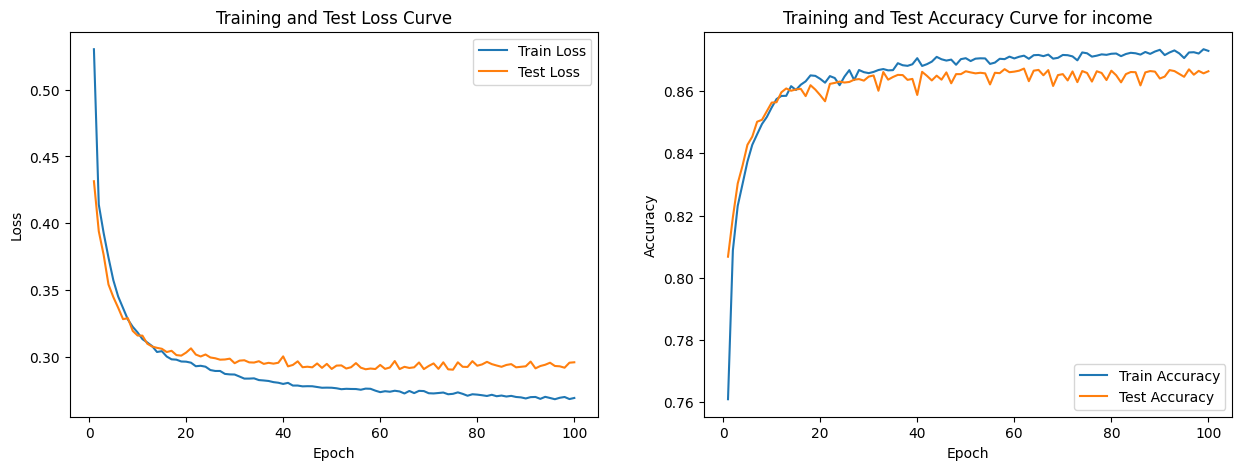

In [11]:
model = Classifier(targets_classes=[2],
                    rff_on=True,
                    n_cont=6,
                    cat_feat=[10,16,7,16,6,5,2,43], 
                   sigma=best_params['sigma'],
                   embed_size=best_params['embed_size'],
                   num_layers=best_params['num_layers'],
                   heads=best_params['heads'],
                   forward_expansion=best_params['forward_expansion'],
                   pre_norm_on=best_params['prenorm_on'],
                   mlp_scale_classification=best_params['mlp_scale_classification'],
                   embedding_dropout=best_params['embedding_dropout'],
                   decoder_dropout=best_params['decoder_dropout'],
                   classification_dropout=best_params['class_drop']
                   ).to(device_in_use) # Instantiate the model
loss_functions = UncertaintyLoss(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = best_params['learning_rate']) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
early_stopping = EarlyStopping(patience=3)
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
train_accuracies_2 = []
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies_1 = []
test_accuracies_2 = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  # test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, income Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, income Accuracy {format_metric(test_accuracy_1)}, income F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

  if early_stopping(test_accuracy_1):
    break

  # total_attention = model.decoder.avg_attention
  # all_attention_scores.append(total_attention.tolist()) #UPDATED
  # model.decoder.avg_attention = None

# Save the model after pre-training
torch.save(model.state_dict(), 'final_model_trained.pth')

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve for income')
plt.legend()


# plt.subplot(1, 3, 3)
# plt.plot(range(1, epochs+1), train_accuracies_2, label='Train Accuracy')
# plt.plot(range(1, epochs+1), test_accuracies_2, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Test Accuracy Curve for Traffic Type')
# plt.legend()
# plt.tight_layout()
# plt.tight_layout()
# plt.show()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

# # Display confusion matrix for the second task (Application Type) on test data
# conf_matrix_2 = confusion_matrix(all_targets_2, all_predictions_2)
# print("Confusion Matrix for Application Type")
# print(conf_matrix_2)

# print(f"Best accuracy: {max(test_accuracies)}")

# # Plot attention scores for each feature over epochs

# # all_attention_scores = all_attention_scores.cpu().numpy() #CUDA tensor needs to be converted to cpu tensor
# all_attention_scores = torch.tensor(all_attention_scores)
# plt.figure(figsize=(10, 6))

# features = df.drop("class1", axis=1).columns.tolist()

# for feature_idx in range(all_attention_scores.shape[1]):
#     plt.plot(all_attention_scores[:, feature_idx], label=features[feature_idx])

# plt.xlabel('Epochs')
# plt.ylabel('Attention Scores')
# plt.title('Attention Scores for Each Feature over Epochs')
# plt.legend(loc = 'lower left')
# plt.show()

# last_epoch_attention_scores = all_attention_scores[-1]
# top_scores, top_indices = torch.topk(last_epoch_attention_scores, k=10)

# # Display the top 10 attention scores and the corresponding feature
# for i in range(10):
#     print(f"{i+1}. {features[int(top_indices[i])]}: {top_scores[i]}")